In [1]:
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import os
import pandas as pd
import re
import sqlite3
import importlib
from findercode.aatrans import AA_translator
from findercode.filename import get_filename
from findercode.filename import read_ini_table
from findercode.subset import get_variant_data
from findercode.subset import subset_dataframe
from findercode.get_groups import get_groups
from findercode.variants import GetVariants
from findercode.variants import SepGroups
from findercode.variants import Variant
from findercode.variants import VntCount

For DEMO please use: example.xlsx

In [6]:
df = read_ini_table(table_name=get_filename())
df

Please enter the name of the excel table of your interest in the format, Name.xlsx:  example.xlsx


,Gene,Mutation Name,DNA Sequence Variation,Tumor Site,Gender,Race
53,CDH1,p.R335*,c.1003C>T,BREAST,F,White
143,CDH1,,c.1008+8G>T,Endometrium,F,White
122,CDH1,p.E336D,c.1008G>C,BREAST,F,White
155,CDH1,p.S337_splice,c.1009_splice,LUNG,M,White
52,CDH1,p.A34Efs*23,c.100_104delGCCGA,BREAST,F,White
204,CDH1,p.F338fs,c.1013_1014TC>T,STOMACH,M,Unknown - Declined
61,CDH1,p.T340A,c.1018A>G,BREAST,F,White
12,CDH1,p.T340M,c.1019C>T,Colon/Rectum,F,White
203,CDH1,p.L343G,c.1027_1028delCTinsGG,STOMACH,M,White
145,CDH1,p.T364S,c.1090A>T,Endometrium,F,White


In [7]:
v = GetVariants()
print(v)
#type(v)

No. of valid variants to work with:
c_change: 0
c_fs: 0
c_splice: 0
g_name: 0
p_FS: 0
p_change: 0



In [8]:
v = get_variant_data(df)
print(v)

<class 'findercode.variants.GetVariants'>
No. of valid variants to work with:
c_change: 118
c_fs: 52
c_splice: 9
g_name: 190
p_FS: 50
p_change: 119



In [9]:
df1, df2, df3 = subset_dataframe(df, v)

In [10]:
df2.head()

,Gene,Mutation Name,DNA Sequence Variation,Tumor Site,Gender,Race
52,CDH1,p.A34Efs*23,c.100_104delGCCGA,BREAST,F,White
204,CDH1,p.F338fs,c.1013_1014TC>T,STOMACH,M,Unknown - Declined
106,CDH1,p.N369Tfs*26,c.1098_1099insGACAC,BREAST,F,White
41,CDH1,p.L396fs,c.1188_1189GA>G,BREAST,F,White
51,CDH1,p.D433fs,c.1298_1306ATGGCATTT>AA,BREAST,F,White


In [11]:
s = get_groups(df1, df2, df3)
print(s)

<class 'findercode.variants.SepGroups'>
No. of variants found per Group:
CdnaFS: 50
Cdna_snv: 118
Cdnaspl: 9
FSstop_pos: 50
WTBsnv: 118
WTBspl: 9
c_fs2: 50
c_splice3: 9
codonFS: 50
codon_snv: 118
offset_pos: 9
p_change1: 118
p_fs2: 50
raw_WTBFS: 50
raw_vnt_BFS: 50
vnt_AA: 118
vnt_AAFS: 50
vnt_Bsnv: 118
vnt_Bspl: 9
wtaa: 118
wtaaFS: 50



In [12]:
# Substitute value None for string None in vnt_AAFS
s["vnt_AAFS"] = ['None' if v is None else v for v in s["vnt_AAFS"]]
print(s["vnt_AAFS"])

['E', 'None', 'T', 'None', 'None', 'None', 'None', 'None', 'S', 'C', 'None', 'K', 'None', 'None', 'None', 'None', 'Q', 'S', 'K', 'H', 'None', 'K', 'H', 'None', 'S', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'R', 'None', 'None', 'None', 'R', 'None', 'None', 'H', 'None', 'None', 'None', 'None', 'None', 'I']


In [13]:
# extracting the translstor from the module
# step 4: translate A for Ala
# Get WTAA and VAA

WTAA_FS = AA_translator(s["wtaaFS"])
vnt_AA_3codeFS = AA_translator(s["vnt_AAFS"])
WTAAsnv = AA_translator(s["wtaa"])
vnt_AA_3code = AA_translator(s["vnt_AA"])


# print(WTAA_FS)
# print(vnt_AA_3codeFS)
# print(WTAAsnv)
# print(vnt_AA_3code)

In [14]:
# ADD fs to the 3 letter for full name

s["FSstop_pos"]  # this is fs list
vnt_AA_3codeFS

vntAA3addFS = []
if len(s["FSstop_pos"]) == len(vnt_AA_3codeFS):
    for ind in range(len(vnt_AA_3codeFS)):
        if vnt_AA_3codeFS[ind] == 'None':
            vntAA3addFS.append(s["FSstop_pos"][ind])
        else:
            vntAA3addFS.append(vnt_AA_3codeFS[ind] + s["FSstop_pos"][ind])
# print(vntAA3addFS)

In [15]:
# Substitute value None for empty str
def sub_nones_empty(vntlist):
    """This function substitutes the value None for an empty string"""
    empstr = ['' if v is None else v for v in vntlist]
    return empstr


WTBFS = sub_nones_empty(s["raw_WTBFS"])
# print(WTBFS)

vnt_BFS = sub_nones_empty(s["raw_vnt_BFS"])
# print(vnt_BFS)

In [16]:
# get full Protein change name with 3 letter AA
#WTAAsnv + codon_snv + vnt_AA_3code

pfullname = []
if len(WTAAsnv) == len(s["codon_snv"]):
    for ind in range(len(s["codon_snv"])):
        pfullname.append(
            "(p." + WTAAsnv[ind] + s["codon_snv"][ind] + vnt_AA_3code[ind] + ")")
else:
    raise ValueError("lists must be equal in length")
# print(pfullname)

In [17]:
snv_vnt_fullname = []
if len(pfullname) == len(v["c_change"]):
    for ind in range(len(v["c_change"])):
        snv_vnt_fullname.append(v["c_change"][ind] + (" ") + pfullname[ind])
else:
    raise ValueError("lists must be equal in length")
# print(snv_vnt_fullname)

In [18]:
pfullnameFS = []
if len(WTAA_FS) == len(s["codonFS"]):
    for ind in range(len(s["codonFS"])):
        pfullnameFS.append(
            "(p." + WTAA_FS[ind] + s["codonFS"][ind] + vntAA3addFS[ind] + ")")
else:
    raise ValueError("lists must be equal in length")
# print(pfullnameFS)

In [19]:
vnt_fullnameFS = []
if len(pfullnameFS) == len(s["c_fs2"]):
    for ind in range(len(s["c_fs2"])):
        vnt_fullnameFS.append(s["c_fs2"][ind] + " " + pfullnameFS[ind])
else:
    raise ValueError("lists must be equal in length")
# print(vnt_fullnameFS)

In [20]:
# From df1 snv variants
snv_vnt_fullname
Gene_snv = df1.Gene
WTAAsnv
s["codon_snv"]
vnt_AA_3code
s["Cdna_snv"]
s["WTBsnv"]
s["vnt_Bsnv"]

# From df2 FS variants
vnt_fullnameFS
Gene_FS = df2.Gene
WTAA_FS
s["codonFS"]
vnt_AA_3codeFS
s["CdnaFS"]
WTBFS
vnt_BFS


# From df3 splice variables
s["c_splice3"]
Gene_spl = df3.Gene
s["Cdnaspl"]
s["WTBspl"]
s["vnt_Bspl"]
s["offset_pos"]

['+8', '+2', '+1', '-4', '+1', '+1', '+3', '-1', '-3']

In [21]:
snv_Table = pd.DataFrame(list(zip(snv_vnt_fullname, Gene_snv, WTAAsnv, s["codon_snv"], vnt_AA_3code, s["WTBsnv"], s["Cdna_snv"], s["vnt_Bsnv"])),
                         columns=['Variant_Name', 'Gene_Name', 'Wildtype_Amino_Acid', 'Codon', 
                                  'Variant_Amino_Acid', 'Wildtype_Seq', 'Cdna_Position_Number', 'Variant_Seq'])
snv_Table.head()

,Variant_Name,Gene_Name,Wildtype_Amino_Acid,Codon,Variant_Amino_Acid,Wildtype_Seq,Cdna_Position_Number,Variant_Seq
0,c.1003C>T (p.Arg335*),CDH1,Arg,335,*,C,1003,T
1,c.1008G>C (p.Glu336Asp),CDH1,Glu,336,Asp,G,1008,C
2,c.1018A>G (p.Thr340Ala),CDH1,Thr,340,Ala,A,1018,G
3,c.1019C>T (p.Thr340Met),CDH1,Thr,340,Met,C,1019,T
4,c.1090A>T (p.Thr364Ser),CDH1,Thr,364,Ser,A,1090,T


In [22]:
FS_Table = pd.DataFrame(list(zip(vnt_fullnameFS, Gene_FS, WTAA_FS, s["codonFS"], vnt_AA_3codeFS, WTBFS, s["CdnaFS"], vnt_BFS)),
                        columns=['Variant_Name', 'Gene_Name', 'Wildtype_Amino_Acid', 'Codon', 
                                 'Variant_Amino_Acid', 'Wildtype_Seq', 'Cdna_Position_Number', 'Variant_Seq'])
FS_Table.head()

,Variant_Name,Gene_Name,Wildtype_Amino_Acid,Codon,Variant_Amino_Acid,Wildtype_Seq,Cdna_Position_Number,Variant_Seq
0,c.100_104delGCCGA (p.Ala34Glufs*23),CDH1,Ala,34,Glu,,100,GCCGA
1,c.1013_1014TC>T (p.Phe338fs),CDH1,Phe,338,None,TC,1013,T
2,c.1098_1099insGACAC (p.Asn369Thrfs*26),CDH1,Asn,369,Thr,,1098,GACAC
3,c.1188_1189GA>G (p.Leu396fs),CDH1,Leu,396,None,GA,1188,G
4,c.1298_1306ATGGCATTT>AA (p.Asp433fs),CDH1,Asp,433,None,ATGGCATTT,1298,AA


In [23]:
Splice_Table = pd.DataFrame(list(zip(s["c_splice3"], Gene_spl, s["WTBspl"], s["Cdnaspl"], s["vnt_Bspl"])),
                            columns=['Variant_Name', 'Gene_Name', 'Wildtype_Seq', 'Cdna_Position_Number', 
                                     'Variant_Seq'])
Splice_Table.head()

,Variant_Name,Gene_Name,Wildtype_Seq,Cdna_Position_Number,Variant_Seq
0,c.1008+8G>T,CDH1,G,1008,T
1,c.1137+2T>A,CDH1,T,1137,A
2,c.1320+1G>C,CDH1,G,1320,C
3,c.1321-4C>G,CDH1,C,1321,G
4,c.1565+1G>A,CDH1,G,1565,A


In [28]:
joining_Tables = snv_Table.append([FS_Table, Splice_Table])
Individual_values_Table = joining_Tables.reindex_axis(snv_Table.columns, axis=1).fillna("")
Individual_values_Table

,Variant_Name,Gene_Name,Wildtype_Amino_Acid,Codon,Variant_Amino_Acid,Wildtype_Seq,Cdna_Position_Number,Variant_Seq
0,c.1003C>T (p.Arg335*),CDH1,Arg,335,*,C,1003,T
1,c.1008G>C (p.Glu336Asp),CDH1,Glu,336,Asp,G,1008,C
2,c.1018A>G (p.Thr340Ala),CDH1,Thr,340,Ala,A,1018,G
3,c.1019C>T (p.Thr340Met),CDH1,Thr,340,Met,C,1019,T
4,c.1090A>T (p.Thr364Ser),CDH1,Thr,364,Ser,A,1090,T
5,c.1093G>A (p.Val365Ile),CDH1,Val,365,Ile,G,1093,A
6,c.1108G>A (p.Asp370Asn),CDH1,Asp,370,Asn,G,1108,A
7,c.1149G>C (p.Gln383His),CDH1,Gln,383,His,G,1149,C
8,c.1162G>A (p.Glu388Lys),CDH1,Glu,388,Lys,G,1162,A
9,c.1198G>A (p.Asp400Asn),CDH1,Asp,400,Asn,G,1198,A


In [25]:
db_conn = sqlite3.connect(":MEMORY:")
curs = db_conn.cursor()
Individual_values_Table.to_sql(
    "Variant_Ref1", db_conn, index=False, if_exists='replace')

In [26]:
sql = "SELECT * FROM Variant_Ref1"
df = pd.read_sql_query(sql, db_conn)
df.head()

,Variant_Name,Gene_Name,Wildtype_Amino_Acid,Codon,Variant_Amino_Acid,Wildtype_Seq,Cdna_Position_Number,Variant_Seq
0,c.1003C>T (p.Arg335*),CDH1,Arg,335,*,C,1003,T
1,c.1008G>C (p.Glu336Asp),CDH1,Glu,336,Asp,G,1008,C
2,c.1018A>G (p.Thr340Ala),CDH1,Thr,340,Ala,A,1018,G
3,c.1019C>T (p.Thr340Met),CDH1,Thr,340,Met,C,1019,T
4,c.1090A>T (p.Thr364Ser),CDH1,Thr,364,Ser,A,1090,T


In [27]:
curs.execute('SELECT Variant_Name FROM Variant_Ref1 WHERE Codon="340"')
curs.fetchall()

[('c.1018A>G (p.Thr340Ala)',), ('c.1019C>T (p.Thr340Met)',)]

In [27]:
db_conn.close()

In [28]:
a = Variant(vname="c.1090A>T (p.Thr364Ser)", gene="CDH1")
print(a)
c = Variant(vname="c.1003C>T (p.Arg335*)", gene="CDH1")
print(c)
d = Variant(vname="c.1018A>G (p.Thr340Ala)", gene="CDH1")
print(d)
d.how_many()

The variant c.1090A>T (p.Thr364Ser), is located in the CDH1 gene
The variant c.1003C>T (p.Arg335*), is located in the CDH1 gene
The variant c.1018A>G (p.Thr340Ala), is located in the CDH1 gene
There are 3 variants to work with.


In [29]:
c.del_variant()

You are deleting the variant c.1003C>T (p.Arg335*)
There are/is 2 more variant(s) to work with.


In [30]:
b = VntCount(vname="c.1090A>T (p.Thr364Ser)", gene="CDH1",
             dataF=Individual_values_Table, dfname="Individual_values_Table")
print(b)

There are 177 CDH1 variants in the Individual_values_Table dataframe.
But you are only working with 3 variants from this table.


In [31]:
def graphing(data_fr):
    graphdb1 = data_fr.drop(["Wildtype_Amino_Acid", "Codon", "Variant_Amino_Acid", "Wildtype_Seq", "Cdna_Position_Number",
                                         "Variant_Seq"], axis=1, inplace=False)
    graphdb = graphdb1.groupby("Gene_Name").count()
    graphdb.columns = ['Variant_Count']
    graphdb.plot(kind='bar', title="No. of Variants found by Gene", color='pink')
    return plt.show()

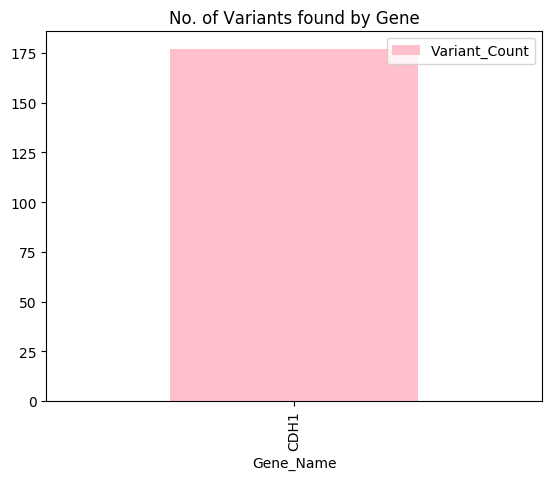

In [32]:
graphing(Individual_values_Table)